In [1]:
import time, os, io
# Tensorflow and numpy!
import tensorflow as tf
import numpy as np

# Matplotlib, so we can graph our functions
# The Agg backend is here for those running this on a server without X sessions
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from decimal import Decimal, getcontext
import math

/home/denis/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### The ReLU network for approximate squaring

In [2]:
def relu(x):
    return np.maximum(x,0)

def sq_approx(x, Nlayers): # 0 <= x <= 1

    def tooth(x):
        return 2.*relu(x)-4.*relu(x-0.5)+2.*relu(x-1.)
        
    out = 1.*x
    for n in range(Nlayers):
        x = tooth(x)
        out -= 2.**(-2*n-2)*x
    
    Nconnections = 7*Nlayers+1
    return out, Nconnections

def sine_approx(x, Nlayers, delta = 0.5): # 0 <= x <= 1

    def tooth(x):
        return (1/delta) *(relu(x+delta) - relu(x) - relu(x-delta) + relu(x-2*delta))
    
    out = 1.*x
    for n in range(Nlayers):
        x = tooth(x)
        out -=  2.**(-2*n-2)*x
    
    Nconnections = 7*Nlayers+1
    return out, Nconnections, delta

def gen_sin(x):
    return [math.sin(num) for num in x]

### Validation

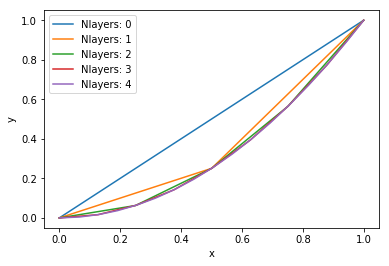

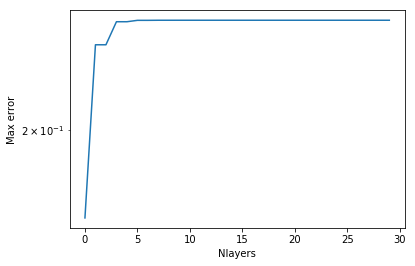

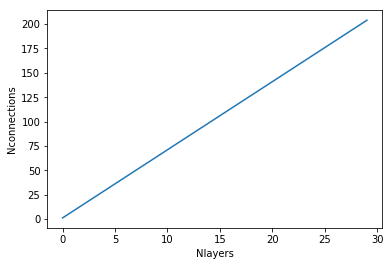

In [3]:
x = np.linspace(0,1,1000)
errL = []
NconnectionsL = []
for Nlayers in range(30):
    res = sine_approx(x, Nlayers=Nlayers)
    errL.append(np.max(np.abs(res[0]-gen_sin(x))))
    NconnectionsL.append(res[1])
    if Nlayers < 5:
        plt.plot(x, sq_approx(x, Nlayers=Nlayers)[0], label='Nlayers: '+str(Nlayers))
    
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
plt.semilogy(range(30), errL)
plt.xlabel('Nlayers')
plt.ylabel('Max error')

plt.figure()
plt.plot(range(30), NconnectionsL)
plt.xlabel('Nlayers')
plt.ylabel('Nconnections')
plt.show()

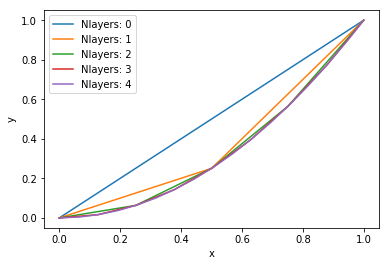

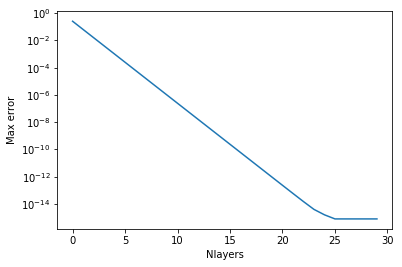

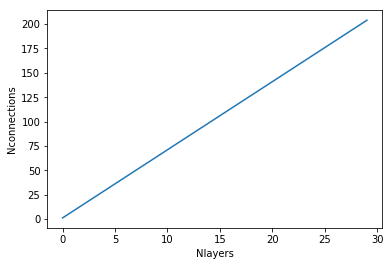

In [4]:
x = np.linspace(0,1,10000)
errL = []
NconnectionsL = []
for Nlayers in range(30):
    res = sq_approx(x, Nlayers=Nlayers)
    errL.append(np.max(np.abs(res[0]-x*x)))
    NconnectionsL.append(res[1])
    if Nlayers < 5:
        plt.plot(x, sq_approx(x, Nlayers=Nlayers)[0], label='Nlayers: '+str(Nlayers))
    
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
plt.semilogy(range(30), errL)
plt.xlabel('Nlayers')
plt.ylabel('Max error')

plt.figure()
plt.plot(range(30), NconnectionsL)
plt.xlabel('Nlayers')
plt.ylabel('Nconnections')
plt.show()

Training our universal approximator
batch: 1000, loss: 0.209821
batch: 2000, loss: 0.200982
batch: 3000, loss: 0.180963
batch: 4000, loss: 0.061136
batch: 5000, loss: 0.020568
batch: 6000, loss: 0.009301
batch: 7000, loss: 0.005259
batch: 8000, loss: 0.006067
batch: 9000, loss: 0.003578
batch: 10000, loss: 0.003335
batch: 11000, loss: 0.003328
batch: 12000, loss: 0.003781
batch: 13000, loss: 0.003614
batch: 14000, loss: 0.003510
batch: 15000, loss: 0.003376
batch: 16000, loss: 0.003312
batch: 17000, loss: 0.003284
batch: 18000, loss: 0.003252
batch: 19000, loss: 0.003295
batch: 20000, loss: 0.004014
batch: 21000, loss: 0.003741
batch: 22000, loss: 0.003356
batch: 23000, loss: 0.003486
batch: 24000, loss: 0.003278
batch: 25000, loss: 0.003449
batch: 26000, loss: 0.003277
batch: 27000, loss: 0.003319
batch: 28000, loss: 0.003278
batch: 29000, loss: 0.003308
batch: 30000, loss: 0.003261
Plotting graphs


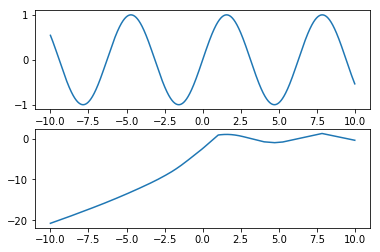

In [5]:
# Our UA function
def univAprox(x, hidden_dim=50):
    # The simple case is f: R -> R
    input_dim = 1 
    output_dim = 1

    with tf.variable_scope('UniversalApproximator'):
        ua_w = tf.get_variable(
            name='ua_w'
            , shape=[input_dim, hidden_dim]
            , initializer=tf.random_normal_initializer(stddev=.1)
        )
        ua_b = tf.get_variable(
            name='ua_b'
            , shape=[hidden_dim]
            , initializer=tf.constant_initializer(0.)
        )
        z = tf.matmul(x, ua_w) + ua_b
        a = tf.nn.relu(z) # we now have our hidden_dim activations

        ua_v = tf.get_variable(
            name='ua_v'
            , shape=[hidden_dim, output_dim]
            , initializer=tf.random_normal_initializer(stddev=.1)
        )
        z = tf.matmul(a, ua_v)

    return z
    
# We define the function we want to approximate
def func_to_approx(x):
    return tf.sin(x)


def main(nb_neurons = 50):

    with tf.variable_scope('Graph') as scope:
        # Our inputs will be a batch of values taken by our functions
        x = tf.placeholder(tf.float32, shape=[None, 1], name="x")

        # We define the ground truth and our approximation 
        y_true = func_to_approx(x)
        y = univAprox(x, nb_neurons)

        # We define the resulting loss and graph it using tensorboard
        with tf.variable_scope('Loss'):
            loss = tf.reduce_mean(tf.square(y - y_true))
            # (Note the "_t" suffix here. It is pretty handy to avoid mixing 
            # tensor summaries and their actual computed summaries)
            loss_summary_t = tf.summary.scalar('loss', loss) 

        # We define our train operation using the Adam optimizer
        adam = tf.train.AdamOptimizer(learning_rate=1e-3)
        train_op = adam.minimize(loss)
        
    # This is some tricks to push our matplotlib graph inside tensorboard
    with tf.variable_scope('TensorboardMatplotlibInput') as scope:
        # Matplotlib will give us the image as a string ...
        img_strbuf_plh = tf.placeholder(tf.string, shape=[]) 
        # ... encoded in the PNG format ...
        my_img = tf.image.decode_png(img_strbuf_plh, 4) 
        # ... that we transform into an image summary
        img_summary = tf.summary.image( 
            'matplotlib_graph'
            , tf.expand_dims(my_img, 0)
        ) 

    # We create a Saver as we want to save our UA after training
    saver = tf.train.Saver()
    with tf.Session() as sess:
        # We create a SummaryWriter to save data for TensorBoard
        result_folder = 'results/' + str(int(time.time()))
        sw = tf.summary.FileWriter(result_folder, sess.graph)
        
        print('Training our universal approximator')
        sess.run(tf.global_variables_initializer())
        for i in range(30000):
            # We uniformly select a lot of points for a good approximation ...
            x_in = np.random.uniform(1, 10, [100000, 1])
            # ... and train on it
            current_loss, loss_summary, _ = sess.run([loss, loss_summary_t, train_op], feed_dict={
                x: x_in
            })
            # We leverage tensorboard by keeping track of the loss in real time
            sw.add_summary(loss_summary, i + 1)

            if (i + 1) % 1000 == 0:
                print('batch: %d, loss: %f' % (i + 1, current_loss))
        
        print('Plotting graphs')
        # We compute a dense enough graph of our functions
        inputs = np.array([ [(i - 1000) / 100] for i in range(2000) ])
        y_true_res, y_res = sess.run([y_true, y], feed_dict={
            x: inputs
        })
        # We plot it using matplotlib
        # (This is some matplotlib wizardry to get an image as a string,
        # read the matplotlib documentation for more information)
        plt.figure(1)
        plt.subplot(211)
        plt.plot(inputs, y_true_res.flatten())
        plt.subplot(212)
        plt.plot(inputs, y_res)
        imgdata = io.BytesIO()
        plt.savefig(imgdata, format='png')
        imgdata.seek(0)
        # We push our graph into TensorBoard
        plot_img_summary = sess.run(img_summary, feed_dict={
            img_strbuf_plh: imgdata.getvalue()
        })
        sw.add_summary(plot_img_summary, i + 1)
        plt.show()

main(1000)